<a href="https://colab.research.google.com/github/sayandeepmaity/vseven_lumi/blob/main/rnn_lstm_gunshot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Class Weights: {np.int64(0): np.float64(5.15035799522673), np.int64(1): np.float64(0.5537593020272004)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.8873 - loss: 0.5019 - val_accuracy: 0.9648 - val_loss: 0.1363
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9735 - loss: 0.0964 - val_accuracy: 0.9917 - val_loss: 0.0561
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9884 - loss: 0.0665 - val_accuracy: 0.9944 - val_loss: 0.0423
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9937 - loss: 0.0458 - val_accuracy: 0.9944 - val_loss: 0.0343
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9947 - loss: 0.0201 - val_accuracy: 0.9963 - val_loss: 0.0309
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9959 - loss: 0.0212 - val_accuracy: 0.9963 - val_loss: 0.0317
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9963 - loss: 0.0168 - val_accuracy: 0.9963 - val_loss: 0.0218
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9943 - loss: 0.0223 - val_accuracy: 

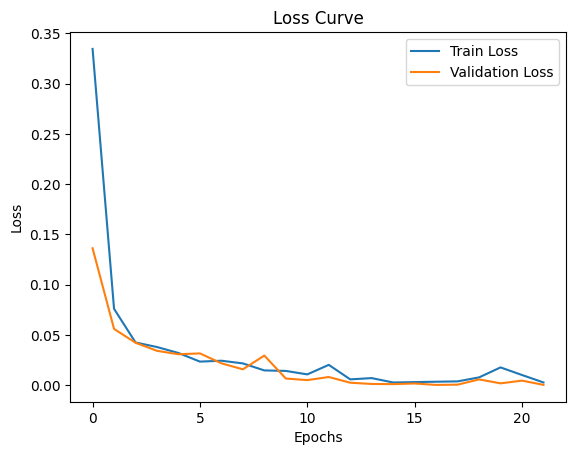

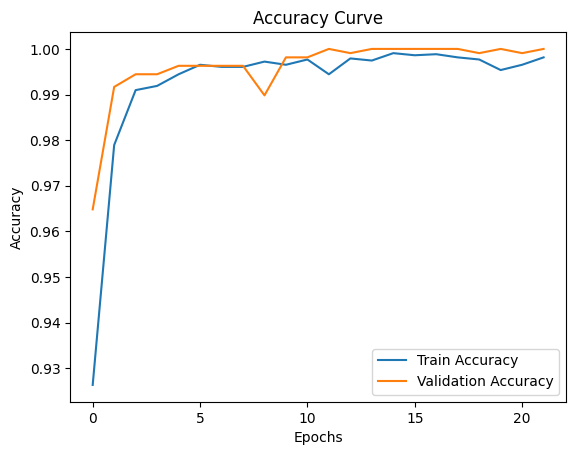

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


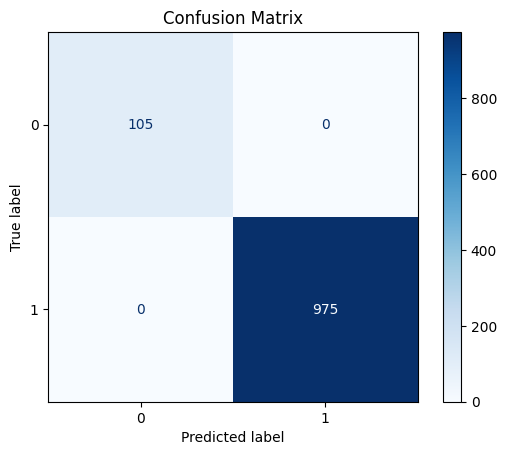

Classification Report:

              precision    recall  f1-score   support

 Non-Gunshot       1.00      1.00      1.00       105
     Gunshot       1.00      1.00      1.00       975

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_features.csv')
non_gunshot_data = pd.read_csv('/content/drive/MyDrive/sevenlumi_data/data_to_fed/cleaned_non_gunshot_features.csv')


drop_columns = ['Gun_Type', 'Distance', 'X', 'Y', 'Z', 'Mic', 'Arrival_Time_Difference']
gunshot_data = gunshot_data.drop(columns=drop_columns)
non_gunshot_data = non_gunshot_data.drop(columns=drop_columns)


data = pd.concat([gunshot_data, non_gunshot_data], ignore_index=True)


X = data.drop(columns=['Gunshot'])
y = data['Gunshot']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)


model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_pred_prob = model.predict(X_test_reshaped)
y_pred = (y_pred_prob > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Non-Gunshot', 'Gunshot']))


In [ ]:

model.save('/content/drive/MyDrive/sevenlumi_data/models/rnn_lstm_gunshot_detector_model.h5')

print("Model saved successfully!")


Model saved successfully!
